## Team 52


*   Anghelo Daniel Pérez Martínez (A01795323)
*   Luis Daniel Ortega Muñoz (A01795197)
*   Emil Khaleb Palomino Bruzzón (A00826811)
*   José de Jesús Peña Rodríguez (A01794940)
*   Gerardo Miguel Pérez Solis (A01795599)

# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

### Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

### Connection to personal Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set local path to Cifar10 folder

In [3]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/MNA/Deep learning/Semana 04/cifar-10-batches-py'

In [4]:
# check if torch cuda is available
torch.cuda.is_available()

False

### **Get and prepare CIFAR10 dataset**

### Define constants

In [ ]:
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

### Data transformation

In [ ]:
# Normalizes a tensor by substracting the mean and dividing by the
# standard deviation for each color channel
# this process will improve the training process
transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

### Split dataset

In [5]:
# Train dataset
# download=True ensures the dataset is downloaded if it is not already downloaded
# in DATA_PATH
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
# wraps dataset into a DataLoader
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
# Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)

# wraps dataset into a DataLoader
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
# Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_cifar)

# wraps dataset into a DataLoader
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# display details of train dataset
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/MNA/Deep learning/Semana 04/cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [7]:
# check batch size
train_loader.batch_size

64

In [ ]:
# Iterates through the training data
# it prints images and lables
for i, (x, y) in enumerate(train_loader):
    print(x, y)

### Check available device (cuda or cpu)

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


### Display a random image

In [30]:
# get the list of labels from test_loader
classes = test_loader.dataset.classes

### Define "plot_figure" function

This function receives an image and displays it using Matplotlib

In [31]:
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

Sample image represents a: ship


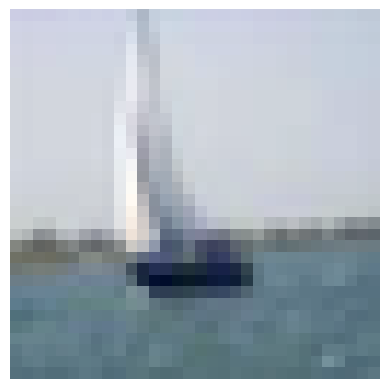

In [32]:
# get a random id
rnd_sample_idx = np.random.randint(len(test_loader))
# print image label
print(f'Sample image represents a: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
# get image by index
image = test_loader.dataset[rnd_sample_idx][0]
# normalize image pixel values
image = (image - image.min()) / (image.max() -image.min() )
# call function to display image
plot_figure(image)

### Define "plot_cifar10_grid" function

This method is created to visualize a grid of CIFAR10 images
it randomly selects 8 samples from each class and displays them in a grid using Matplotlib

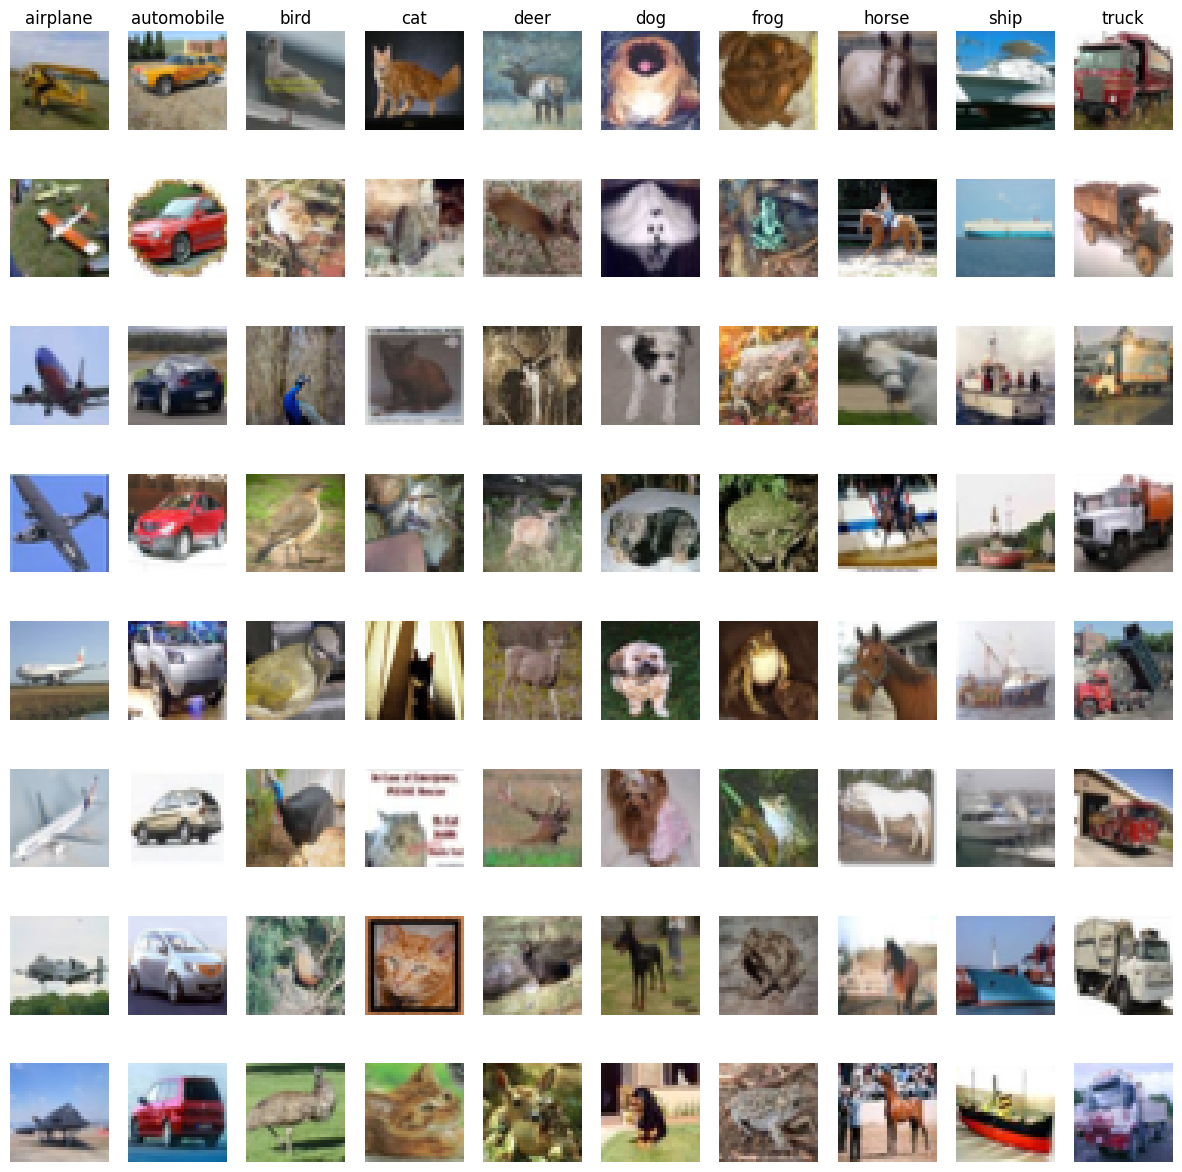

In [10]:
def plot_cifar10_grid():
    # get the list of class names
    classes = test_loader.dataset.classes
    # define number of images from each class
    total_samples = 8
    # create a figure with size of 15x15
    plt.figure(figsize=(15,15))
    # loop over the classes
    for label, sample in enumerate(classes):
        # get indices of all images that belong to the current class
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        # select images from each class, randomly
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        # loop over the randomly selected images
        for i, idx in enumerate(sample_idxs):
            # define the position of each image in the grid
            plt_idx = i*len(classes) + label + 1
            # add image to the grid
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            # remove labels
            plt.axis('off')
            # if the image is the first in the column, adds a title
            if i == 0: plt.title(sample)
    # display the grid
    plt.show()

# call the function
plot_cifar10_grid()

### Define "accuracy" function

This method calculates the accuracy of a given model, it compares the model's predictions with the actual labels

In [11]:
# model: Neural network model to evaluate
# loader: dataset to be avaluated
def accuracy(model, loader):
  # Initializing counters
  num_correct = 0
  num_total = 0
  # set model to evaluation mode
  model.eval()
  # disable gradient calculation because this is not needed during evaluation
  with torch.no_grad():
      # loop through the batches in loader
      # x: images
      # y: labels
      for x, y in loader:
          # move x to specified device
          x = x.to(device)
          # move y to specified device
          y = y.to(device)
          # take predictions from model
          scores = model(x)
          # returns max score for each sample
          # and indices of predicted classes
          _, preds = scores.max(1)
          # number of correct predictions is added to num_correct
          num_correct += (preds == y).sum().item()
          # count total samples
          num_total += preds.size(0)
  # returns accuracy
  return num_correct/num_total

### Define "train" function

it defines a training loop for the linear and Convolutional Neural Network models we will use in this exercise


In [12]:
# model: neural network model that will be trained
# optimizer: optimization algorithm
# epochs: number of times the entire dataset is through the model
def train(model, optimizer, epochs=100):
    # ensures the model is sent to the specified device
    model = model.to(device)
    # loop that runs "epochs" number of times
    for epoch in range(epochs):
        # Enables training mode
        model.train()
        # keep track of cumulative loss for each epoch
        # it will accumulate loss for each batch
        # and reset at the start of the epoch
        current_loss = 0.0
        # loop that iterares through batches in train_loader
        for i, (x, y) in enumerate(train_loader):
            # send the input batch x to the specified device and ensures the
            # data type is float32
            x = x.to(device=device, dtype=torch.float32)
            # send the y labels to the specified device and ensures data type is long
            y = y.to(device=device, dtype=torch.long)

            # Forward pass
            # the model takes a batch of images "x" and produces output
            # predictions called scores
            scores = model(x)
            # Cross entropy loss function
            # compares model predictions (scores) with true lables (y)
            # to calculate the loss
            loss = F.cross_entropy(input=scores, target=y)

            # Backward pass and optimization
            # clear previous gradients, they accumulate by default in PyTorch
            optimizer.zero_grad()
            # calculate gradients of loss using backpropagation
            loss.backward()
            # updates model parameters to minimize loss
            optimizer.step()

            # current loss added to cumulative loss
            current_loss += loss.item()

        # Validate each epoch
        # measure model performance after each epoch using accuracy function
        acc = accuracy(model, val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {current_loss/len(train_loader):.4f}, Accuracy: {acc:.4f}')

### **Linear model**

Define a neural network model using nn.Sequential (to stack layers in PyTorch)
The model is fully connected and works with flattened data

### Parameters definition

In [19]:
# number of neurons of the first hidden layer
hidden1 = 512
# number of neurons of the second hidden layer
hidden2 = 256
# learning rate for the optimizer
learning_rate = 0.01
# number of iterations over the entire dataset
epochs = 10

### Model definition

Notes:
nn.Sequential PyTorch method: stacks the layers in the order they are defined, allowing data to flow through them sequentially

In [14]:
linearModel = nn.Sequential(
    # flattens the input from a 3D structure into a 1D vector
    # for example, a 32x32x3 structure to a 1D array of 3,072 elements
    nn.Flatten(),
    # this layer takes 32x32x3 features and outputs hidden1 (512) neurons
    # it uses ReLU activation to introduce non-linearity
    nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
    # this layer takes the output from the previous layer (hidden1=512 neurons)
    # and maps them to hidden2 (256) neurons
    nn.Linear(in_features=hidden1, out_features=hidden2), nn.ReLU(),
    # the final layer takes the output from the previos layer (hidden2)
    # and maps them to the 10 neurons that represent the 10 CIFAR10 classes
    nn.Linear(in_features=hidden2, out_features=10)
)

### Optimizer definition

Using Adam optimizer which is an algorithm that adjusts the learning rate

In [15]:
# pass the model parameters and define the learning rate
optimizer = torch.optim.Adam(linearModel.parameters(), lr=learning_rate)

### Training the linear model

Using the Adam optimizer and epochs previously defined

In [20]:
train(linearModel, optimizer, epochs)

Epoch [1/10], Loss: 2.0614, Accuracy: 0.2146
Epoch [2/10], Loss: 2.0652, Accuracy: 0.1968
Epoch [3/10], Loss: 2.0566, Accuracy: 0.2126
Epoch [4/10], Loss: 2.0488, Accuracy: 0.2272
Epoch [5/10], Loss: 2.0520, Accuracy: 0.2000
Epoch [6/10], Loss: 2.0419, Accuracy: 0.1912
Epoch [7/10], Loss: 2.0332, Accuracy: 0.1978
Epoch [8/10], Loss: 2.0523, Accuracy: 0.1762
Epoch [9/10], Loss: 2.0568, Accuracy: 0.1804
Epoch [10/10], Loss: 2.0653, Accuracy: 0.2008


## **Sequential CNN**

### Defines "conv_k_3" lambda function

This function takes 2 parameters channel1 and channel 2 and returns a 2D convolutional layer



*   in_channels: number of input channels
*   out_channlers: number of feature maps returned by the layer
*   kenel_size: size of convolution filter (3x3)
*   padding: adds padding of 1 pixel to ensure the output will have the same dimensions as the input

It will help simplify the code of the CNNModel class



In [21]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1)

### Define a Convolutional Neural Network class

CNNModel inherits from nn.Module (base class for neural network modesl in PyTorch, it contains functionalitites like backpropagation)



In [22]:
class CNNModel(nn.Module):
    # intialize the layers of the CNN
    def __init__(self, in_channel, channel1, channel2):
      super().__init__()
      # conv1: 2d Convolutional layer, kernel size: 3x3, padding: 1
      self.conv1 = conv_k_3(in_channel, channel1)
      # bn1: batch normalization, it normalizes the activations of conv1
      self.bn1 = nn.BatchNorm2d(channel1)
      # conv2: 2d Convolutional layer, it takes the output of the previos layer
      # (channel 1) as the input and produces channel2 output channels
      self.conv2 = conv_k_3(channel1, channel2)
      # bn2: normilizes the output of conv2
      self.bn2 = nn.BatchNorm2d(channel2)
      # reduce spatial dimensions of feature maps using kernel = 2 and stride = 2
      self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # define data flow through the network layers
    def forward(self, x):
      # x is a batch of images
      # apply conv1 to input x
      # then, apply batch normalization bn1
      # then, use ReLU activation for non-linearity
      # pass the output through conv2
      # apply batch normalization bn2
      # finally, use ReLU activation
      x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
      # applying max pooling to reduce its spatial size while keeping most
      # important features
      return self.max_pool(x)

## **Define a Convolutional Neural Network**

### Channel variables

In [23]:
# first convolutional layer, outputs 16 feature maps
channel1 = 16
# second convolutional layer, output 32 feature maps
channel2 = 32
# third convolutional layer, output 64 feature maps
channel3 = 64
# foruth convolutional layer, output 128 feature maps
channel4 = 128

### Training hyperparameters

In [24]:
# the model will be trained for 'x' number of epochs
epochs = 10
# "step" size for the optimizer during training
learning_rate = 1e-2

### Model definition

Notes:
* CIFAR10 images are RGB, therefore has 3 color channels
* CIFAR10 has 10 categories
* 3D feature maps need to be flattened into a 1D vector to be input of the fully connected layer

In [25]:
modelCNN = nn.Sequential(
              # 3 input channels
              # channel 1: 16 output channels
              # channel 2: 32 output channels
              CNNModel(3, channel1, channel2),
              # input channel is the 32 feature map from channel 2
              # hannel3 and chanel 4 are the new output channels
              # it outputs a 128 feature map (channel 4)
              CNNModel(channel2, channel3, channel4),
              # flat output into a 1D tensor
              nn.Flatten(),
              # linear layer to output 10 neurons representing one of
              # the 10 possible classes from CIFAR10
              # receives a 8x8x128 flattened feature map (8,192 features)
              # 8(height) x 8 (width) x 128 (depth)
              nn.Linear(in_features=8*8*channel4, out_features=10)
            )

### Optimizer setup

It creates an Adam (Adaptative Moment Estimation) optimizer

It is an optimization algorithm, it adapts the learning rate for each parameter in the model automatically. Parameters with large gradients will have their learning rate reduced, while parameters with small gradients will have their learning rate increased.




In [26]:
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)

### Training CNN model

In [28]:
train(modelCNN, optimizer, epochs)

Epoch [1/10], Loss: 2.1872, Accuracy: 0.5596
Epoch [2/10], Loss: 1.1021, Accuracy: 0.6586
Epoch [3/10], Loss: 0.8757, Accuracy: 0.7042
Epoch [4/10], Loss: 0.7594, Accuracy: 0.7126
Epoch [5/10], Loss: 0.6687, Accuracy: 0.7312
Epoch [6/10], Loss: 0.6004, Accuracy: 0.7310
Epoch [7/10], Loss: 0.5416, Accuracy: 0.7270
Epoch [8/10], Loss: 0.5010, Accuracy: 0.7354
Epoch [9/10], Loss: 0.4467, Accuracy: 0.7386
Epoch [10/10], Loss: 0.3998, Accuracy: 0.7460


### **Get the accuracy of the Linear Model**

In [27]:
accuracyLinearModel = accuracy(linearModel, test_loader)
print(f'Accuracy of Linear Model: {accuracyLinearModel}')

Accuracy of Linear Model: 0.1976


### **Get the accuracy of the CNN Model**

In [29]:
accuracyCNNModel = accuracy(modelCNN, test_loader)
print(f'Accuracy of CNN Model: {accuracyCNNModel}')

Accuracy of CNN Model: 0.7396


### **Conclusions**

**CNN archirecture**

The CIFAR10 dataset contains images of 32x32 pixes and 3 color channels (RGB), and 10 classes, based on this information we had to implement a CNN model.

The PyTorch method nn.Senquential was selected to build and architecture of 2 CNN layers + 1 flatten layer + fully connected layer. The CNN layers captures low-level and high-level features from the images, the flatten layer prepares the feature map for classification, and the fully connected layer classifies the image into one of the ten categories

The first CNN layer is meant to capture simple image features like edges and textures, and the second CNN layer should capture more complex features like shapes and specific parts. The number of feature maps increase with each block (from 16 to 128), this lets the network to extract richer information.

The pooling layer of the CNNModel class reduces the spatial dimension of the feature map which helps the network focus on higher level features and reduce the computation cost.





**CNN vs Linear**

The results of the CNN on the CIFAR10 dataset is drastically better compared to the results obtained with the linear model, this is proof that CNN work very well with images



**Final accuracy of CNN Model: 0.7396**

